# Pusher-Gym Training on Google Colab

**Quick Setup for Training SAC/PPO on Pusher-v5**

This notebook allows you to:
- Train agents with GPU acceleration
- Save checkpoints to Google Drive
- Record videos of trained agents
- Resume training from checkpoints
- Monitor training progress

---

## 1. Setup Environment

In [1]:
# Check if we're in Colab
try:
    import google.colab
    IN_COLAB = True
    print("✅ Running in Google Colab")
except:
    IN_COLAB = False
    print("ℹ️ Running locally")

ℹ️ Running locally


In [2]:
# Mount Google Drive
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✅ Google Drive mounted")

In [3]:
# Install dependencies
if IN_COLAB:
    !pip install -q gymnasium[mujoco]
    !pip install -q imageio imageio-ffmpeg
    !pip install -q torch torchvision torchaudio
    print("✅ Dependencies installed")

## 2. Upload Project Files

Upload your source files or clone from GitHub.

In [4]:
import os
from pathlib import Path

if IN_COLAB:
    # Option 1: Clone from GitHub (recommended)
    # Uncomment and modify with your repo URL
    # !git clone https://github.com/YOUR_USERNAME/Pusher-Gym.git /content/Pusher-Gym
    
    # Option 2: Upload files manually
    from google.colab import files
    print("📤 Please upload your source files")
    print("   Required: sac.py, replay_buffer.py, logger.py, record_video.py")
    print("\nClick 'Choose Files' below to upload...\n")
    uploaded = files.upload()
    
    # Create project structure
    project_root = Path('/content/Pusher-Gym')
    project_root.mkdir(exist_ok=True)
    
    (project_root / 'src' / 'agents').mkdir(parents=True, exist_ok=True)
    (project_root / 'src' / 'utils').mkdir(parents=True, exist_ok=True)
    
    # Move uploaded files
    for filename in uploaded.keys():
        if 'sac' in filename or 'ppo' in filename:
            os.rename(filename, project_root / 'src' / 'agents' / filename)
        else:
            os.rename(filename, project_root / 'src' / 'utils' / filename)
    
    # Add __init__.py files
    (project_root / 'src' / '__init__.py').touch()
    (project_root / 'src' / 'agents' / '__init__.py').touch()
    (project_root / 'src' / 'utils' / '__init__.py').touch()
    
    # Add to Python path
    import sys
    sys.path.insert(0, str(project_root))
    
    print("\n✅ Project structure created")
else:
    project_root = Path.cwd()

## 3. Setup Directories

In [5]:
# Set up directories
if IN_COLAB:
    drive_root = Path('/content/drive/MyDrive/Pusher-Gym')
    drive_root.mkdir(exist_ok=True)
    
    checkpoint_dir = drive_root / 'checkpoints'
    video_dir = drive_root / 'videos'
    log_dir = drive_root / 'logs'
else:
    checkpoint_dir = project_root / 'checkpoints'
    video_dir = project_root / 'videos'
    log_dir = project_root / 'logs'

checkpoint_dir.mkdir(exist_ok=True)
video_dir.mkdir(exist_ok=True)
log_dir.mkdir(exist_ok=True)

print("📁 Directories:")
print(f"  Checkpoints: {checkpoint_dir}")
print(f"  Videos:      {video_dir}")
print(f"  Logs:        {log_dir}")

📁 Directories:
  Checkpoints: C:\Users\USER\PycharmProjects\Pusher-Gym\notebooks\checkpoints
  Videos:      C:\Users\USER\PycharmProjects\Pusher-Gym\notebooks\videos
  Logs:        C:\Users\USER\PycharmProjects\Pusher-Gym\notebooks\logs


## 4. Check GPU

In [6]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✅ GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    device = torch.device("cpu")
    print("⚠️ No GPU available, using CPU")
    print("   Note: Training will be slower on CPU")

⚠️ No GPU available, using CPU
   Note: Training will be slower on CPU


## 5. Import Libraries

In [7]:

import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from datetime import datetime
from tqdm import tqdm
import pickle
from src.environments.wrappers import DenseRewardWrapper

import sys

# Install MoviePy if missing
try:
    import moviepy
except ImportError:
    print("📦 Installing MoviePy...")
    if IN_COLAB:
        !pip install -q moviepy
    else:
        print("⚠️ MoviePy not found. Install with: pip install moviepy")
    import moviepy

# Import our implementations
from src.agents.sac import SACAgent
from src.utils.logger import TrainingLogger
from src.utils.record_video import record_evaluation_episodes

print("✅ All imports successful")

✅ All imports successful


## 6. Training Configuration

In [ ]:
config = {
    # Environment
    'env_name': 'Pusher-v5',
    'seed': 42,
    
    # Algorithm
    'algo': 'sac',
    
    # Training (OPTIMIZED)
    'episodes': 10000,
    'max_steps': 100,
    'warmup_episodes': 50,  # More warmup for exploration
    
    # Evaluation
    'eval_freq': 100,
    'eval_episodes': 10,
    
    # Checkpointing
    'save_freq': 500,
    'auto_resume': True,
    
    # Video recording
    'record_video': True,
    'video_freq': 1000,
    
    # SAC hyperparameters (OPTIMIZED)
    'hidden_dim': 256,
    'lr': 1e-4,
    'gamma': 0.98,
    'tau': 0.02,
    'batch_size': 256,
    'alpha': 0.2,
    'target_entropy': -3.0,
    
    #  OPTIMIZED REWARD SHAPING
    'distance_scale': 5.0,      # Much stronger
    'progress_scale': 100.0,     # Huge progress reward
    'success_bonus': 500.0,      # Massive success bonus
    'touch_bonus': 10.0,         # NEW: Encourage touching
    'stage_bonuses': [10, 30, 70],  # NEW: Milestone rewards
    'action_penalty': 0.01,
    
    'use_dense_rewards': True,   
    'reward_tuning': {
        'reward_dist_weight': 5.0,     
        'reward_near_weight': 2.0,      
        'reward_control_weight': 0.01,  
    },

    # GPU-specific settings
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_workers': 4,               # CPU workers for data loading (if needed)
    'pin_memory': True,     
    
    # Directories
    'checkpoint_dir': str(checkpoint_dir),
    'video_dir': str(video_dir),
    'log_dir': str(log_dir),
    
    # Experiment
    'exp_name': f"sac_pusher_gpu_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
}

# Print GPU info
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"🖥️  GPU: {gpu_name}")
    print(f"   Memory: {gpu_memory:.1f} GB")
    print(f"   Batch size optimized: {config['batch_size']}")
else:
    print("⚠️  No GPU! Training will be slow.")
    config['batch_size'] = 256  # Reduce for CPU

print("\n📋 GPU-Optimized Configuration:")
print("=" * 80)
for key, value in config.items():
    if not key.endswith('_dir'):
        print(f"  {key:25s}: {value}")
print("=" * 80)

📋 Optimized Configuration:
  env_name                 : Pusher-v5
  seed                     : 42
  algo                     : sac
  episodes                 : 25000
  max_steps                : 100
  warmup_episodes          : 50
  eval_freq                : 100
  eval_episodes            : 10
  save_freq                : 500
  auto_resume              : True
  record_video             : True
  video_freq               : 1000
  hidden_dim               : 256
  lr                       : 0.0005
  gamma                    : 0.98
  tau                      : 0.005
  batch_size               : 256
  alpha                    : 0.2
  target_entropy           : -3.0
  distance_scale           : 5.0
  progress_scale           : 100.0
  success_bonus            : 500.0
  touch_bonus              : 10.0
  stage_bonuses            : [10, 30, 70]
  action_penalty           : 0.01
  use_dense_rewards        : True
  reward_tuning            : {'reward_dist_weight': 2.0, 'reward_near_weight': 1.0, 

## 7. Create Environment and Agent

In [ ]:
# Cell 7: GPU-Optimized Environment and Agent

# Set seeds
np.random.seed(config['seed'])
torch.manual_seed(config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed(config['seed'])
    torch.backends.cudnn.deterministic = True  # ⭐ Reproducibility
    torch.backends.cudnn.benchmark = True      # ⭐ Speed optimization

# Create environments
env = gym.make(
    config['env_name'],
    reward_dist_weight=config['reward_tuning']['reward_dist_weight'],
    reward_near_weight=config['reward_tuning']['reward_near_weight'],
    reward_control_weight=config['reward_tuning']['reward_control_weight']
)

eval_env = gym.make(
    config['env_name'],
    reward_dist_weight=config['reward_tuning']['reward_dist_weight'],
    reward_near_weight=config['reward_tuning']['reward_near_weight'],
    reward_control_weight=config['reward_tuning']['reward_control_weight']
)

env.reset(seed=config['seed'])
eval_env.reset(seed=config['seed'] + 1000)

# Get dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print(f"🌍 Environment: {config['env_name']}")
print(f"  State dim: {state_dim}")
print(f"  Action dim: {action_dim}")

# ⭐ CREATE GPU-OPTIMIZED AGENT
agent = SACAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    hidden_dim=config['hidden_dim'],
    lr=config['lr'],
    gamma=config['gamma'],
    tau=config['tau'],
    alpha=config['alpha'],
    automatic_entropy_tuning=True,
    device=config['device']  # ⭐ Use GPU device
)

# Set target entropy
if hasattr(agent, 'target_entropy'):
    agent.target_entropy = config['target_entropy']

print(f"\n🤖 Agent: {config['algo'].upper()}")
print(f"  Device: {config['device']}")
print(f"  Parameters: {sum(p.numel() for p in agent.actor.parameters()):,}")
print(f"  Batch size: {config['batch_size']} (GPU-optimized)")

# ⭐ MEMORY OPTIMIZATION: Enable gradient checkpointing if needed
if torch.cuda.is_available():
    # Set memory growth strategy
    torch.cuda.empty_cache()
    print(f"\n💾 GPU Memory:")
    print(f"  Allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print(f"  Reserved: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")

print("\n🚀 Ready for GPU-accelerated training!")
print("=" * 80)

✅ Using TUNED reward weights:
   reward_dist (distance): 2.0
   reward_near (fingertip): 1.0
   reward_ctrl (action penalty): 0.05

🌍 Environment: Pusher-v5
  State dim: 23
  Action dim: 7
  Target entropy: -3.0

🤖 Agent: SAC
  Device: cpu
  Parameters: 75,534
  Learning rate: 0.0005
  Gamma: 0.98
  Tau: 0.005

🚀 Ready to train with TUNED hyperparameters!


## 8. Check for Existing Checkpoints

In [10]:
# Cell 8: Check for Existing Checkpoints (UPDATED)

import glob
import re
import os

def find_latest_checkpoint(checkpoint_dir, exp_name=None):
    """
    Find the latest checkpoint, handling various naming schemes.
    
    Supports:
    - Episode-based: exp_name_ep1000.pt
    - Best model: exp_name_best.pt
    - Final: exp_name_final.pt
    - Generic: any .pt file
    
    Returns:
        (checkpoint_path, episode_number, checkpoint_type)
    """
    checkpoint_dir = str(checkpoint_dir)
    
    if not os.path.exists(checkpoint_dir):
        print(f"⚠️ Checkpoint directory not found: {checkpoint_dir}")
        return None, 0, None
    
    checkpoints = glob.glob(os.path.join(checkpoint_dir, "*.pt"))
    
    if not checkpoints:
        print(f"ℹ️ No checkpoints found in {checkpoint_dir}")
        return None, 0, None
    
    print(f"\n📂 Found {len(checkpoints)} checkpoint(s):")
    for cp in sorted(checkpoints):
        print(f"   - {os.path.basename(cp)}")
    
    best_checkpoint = None
    best_episode = 0
    checkpoint_type = None
    
    for cp in checkpoints:
        basename = os.path.basename(cp)
        
        # Priority 1: Episode-based checkpoints (most recent training)
        match = re.search(r'_ep(\d+)\.pt$', basename)
        if match:
            episode = int(match.group(1))
            if episode > best_episode:
                best_episode = episode
                best_checkpoint = cp
                checkpoint_type = 'episode'
        
        # Priority 2: Best model (if no episode checkpoints)
        elif 'best' in basename and best_episode == 0:
            best_checkpoint = cp
            best_episode = 0
            checkpoint_type = 'best'
        
        # Priority 3: Final model (if no other checkpoints)
        elif 'final' in basename and best_checkpoint is None:
            best_checkpoint = cp
            best_episode = 0
            checkpoint_type = 'final'
    
    if best_checkpoint:
        print(f"\n✅ Selected: {os.path.basename(best_checkpoint)}")
        if checkpoint_type == 'episode':
            print(f"   Type: Episode checkpoint")
            print(f"   Episode: {best_episode}")
        else:
            print(f"   Type: {checkpoint_type.capitalize()} model")
        
        return best_checkpoint, best_episode, checkpoint_type
    
    return None, 0, None


# Check for checkpoints with more tolerance
start_episode = 0
training_stats = {
    'episode_rewards': [],
    'episode_lengths': [],
    'episode_distances': [],
    'eval_episodes': [],
    'eval_rewards': [],
    'eval_success_rates': [],
    'eval_mean_distances': [],
}

if config['auto_resume']:
    print("\n🔍 Looking for checkpoints to resume from...\n")
    
    checkpoint_path, start_episode, cp_type = find_latest_checkpoint(
        config['checkpoint_dir']
    )
    
    if checkpoint_path:
        try:
            print(f"\n📂 Loading checkpoint...")
            agent.load(checkpoint_path)
            print(f"✅ Agent loaded successfully")
            
            # Try to load stats
            stats_files = glob.glob(os.path.join(config['log_dir'], "*_stats.pkl"))
            
            if stats_files:
                # Load the most recent stats file
                stats_files.sort(key=os.path.getctime, reverse=True)
                latest_stats = stats_files[0]
                
                with open(latest_stats, 'rb') as f:
                    loaded_stats = pickle.load(f)
                    training_stats = loaded_stats
                
                print(f"✅ Training statistics loaded")
                print(f"   Episodes completed: {len(training_stats['episode_rewards'])}")
                print(f"   Evaluations: {len(training_stats['eval_episodes'])}")
                
                if training_stats['eval_rewards']:
                    best_eval = max(training_stats['eval_rewards'])
                    print(f"   Best evaluation reward: {best_eval:.2f}")
            else:
                print(f"⚠️ No training statistics found, starting fresh stats")
            
            print(f"\n{'='*80}")
            print(f"🚀 RESUMING TRAINING FROM EPISODE {start_episode + 1}")
            print(f"{'='*80}\n")
            
        except Exception as e:
            print(f"❌ Error loading checkpoint: {e}")
            print(f"⚠️ Starting fresh training instead\n")
            start_episode = 0
            training_stats = {
                'episode_rewards': [],
                'episode_lengths': [],
                'episode_distances': [],
                'eval_episodes': [],
                'eval_rewards': [],
                'eval_success_rates': [],
                'eval_mean_distances': [],
            }
    else:
        print(f"\n{'='*80}")
        print(f"🆕 NO PREVIOUS CHECKPOINTS FOUND - STARTING FRESH")
        print(f"{'='*80}\n")
else:
    print("\n{'='*80}")
    print(f"ℹ️ Auto-resume disabled - Starting from scratch")
    print(f"{'='*80}\n")


🔍 Looking for checkpoints to resume from...


📂 Found 102 checkpoint(s):
   - sac_pusher_20251028_203932_best.pt
   - sac_pusher_20251028_203932_ep100.pt
   - sac_pusher_20251028_203932_ep1000.pt
   - sac_pusher_20251028_203932_ep1100.pt
   - sac_pusher_20251028_203932_ep1200.pt
   - sac_pusher_20251028_203932_ep1300.pt
   - sac_pusher_20251028_203932_ep1400.pt
   - sac_pusher_20251028_203932_ep1500.pt
   - sac_pusher_20251028_203932_ep1600.pt
   - sac_pusher_20251028_203932_ep1700.pt
   - sac_pusher_20251028_203932_ep1800.pt
   - sac_pusher_20251028_203932_ep1900.pt
   - sac_pusher_20251028_203932_ep200.pt
   - sac_pusher_20251028_203932_ep2000.pt
   - sac_pusher_20251028_203932_ep300.pt
   - sac_pusher_20251028_203932_ep400.pt
   - sac_pusher_20251028_203932_ep500.pt
   - sac_pusher_20251028_203932_ep600.pt
   - sac_pusher_20251028_203932_ep700.pt
   - sac_pusher_20251028_203932_ep800.pt
   - sac_pusher_20251028_203932_ep900.pt
   - sac_pusher_20251028_203932_final.pt
   - sac_pushe

## 9. Training Loop

In [ ]:
# Cell 9: Training Loop with Documentary Recording (UPDATED)

import time
from src.utils.persistent_logger import PersistentTrainingLogger
from src.utils.documentary_recorder import DocumentaryRecorder

def evaluate_agent(agent, env, num_episodes=10):
    """Evaluate agent performance."""
    episode_rewards = []
    final_distances = []
    success_count = 0

    for _ in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0

        for step in range(config['max_steps']):
            action = agent.select_action(state, evaluate=True)
            state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward

            if terminated or truncated:
                break

        final_distance = np.linalg.norm(state[17:20] - state[20:23])
        episode_rewards.append(episode_reward)
        final_distances.append(final_distance)

        if final_distance < 0.05:
            success_count += 1

    return {
        'mean_reward': np.mean(episode_rewards),
        'std_reward': np.std(episode_rewards),
        'mean_distance': np.mean(final_distances),
        'success_rate': success_count / num_episodes * 100,
        'success_count': success_count
    }

# ⭐ Initialize persistent logger
logger = PersistentTrainingLogger(
    log_dir=config['log_dir'],
    experiment_name=config['exp_name'],
    auto_save_freq=10  # Save every 10 episodes
)

# ⭐ Initialize documentary recorder
recorder = DocumentaryRecorder(
    video_dir=config['video_dir'],
    experiment_name=config['exp_name']
)

# Training loop
print("🚀 Starting training with documentary recording...\n")
print("=" * 80)

total_steps = 0
best_reward = -float('inf')
start_time = time.time()

# Track metrics for aggregation
step_metrics = {
    'critic_losses': [],
    'actor_losses': [],
    'alphas': [],
    'q_values': []
}

for episode in tqdm(range(start_episode, config['episodes']), desc="Training"):
    state, _ = env.reset()
    episode_reward = 0
    episode_steps = 0

    # Reset step metrics
    for key in step_metrics:
        step_metrics[key].clear()

    for step in range(config['max_steps']):
        # Select action
        if episode < config['warmup_episodes']:
            action = env.action_space.sample()
        else:
            action = agent.select_action(state, evaluate=False)

        # Step
        next_state, reward, terminated, truncated, _ = env.step(action)

        # Store
        agent.replay_buffer.push(state, action, reward, next_state,
                                terminated or truncated)

        episode_reward += reward
        episode_steps += 1
        total_steps += 1

        # Update
        if (agent.replay_buffer.is_ready(config['batch_size']) and
            episode >= config['warmup_episodes']):
            metrics = agent.update(config['batch_size'])

            # Collect metrics
            step_metrics['critic_losses'].append(metrics.get('critic_loss', 0))
            step_metrics['actor_losses'].append(metrics.get('actor_loss', 0))
            step_metrics['alphas'].append(metrics.get('alpha', 0))
            step_metrics['q_values'].append(metrics.get('q1_mean', 0))

        state = next_state

        if terminated or truncated:
            break

    # Calculate episode statistics
    final_distance = np.linalg.norm(state[17:20] - state[20:23])
    success = final_distance < 0.05

    # ⭐ LOG TO PERSISTENT LOGGER
    episode_data = {
        'episode': episode + 1,
        'reward': episode_reward,
        'length': episode_steps,
        'distance': final_distance,
        'success': success,
        'mean_critic_loss': np.mean(step_metrics['critic_losses']) if step_metrics['critic_losses'] else 0,
        'mean_actor_loss': np.mean(step_metrics['actor_losses']) if step_metrics['actor_losses'] else 0,
        'mean_alpha': np.mean(step_metrics['alphas']) if step_metrics['alphas'] else 0,
        'mean_q_value': np.mean(step_metrics['q_values']) if step_metrics['q_values'] else 0,
    }
    logger.log_episode(episode_data)

    # ⭐ PERIODIC CHECKPOINT
    if (episode + 1) % config['save_freq'] == 0:
        checkpoint_path = os.path.join(config['checkpoint_dir'],
                                      f"{config['exp_name']}_ep{episode+1}.pt")
        agent.save(checkpoint_path)
        print(f"💾 Checkpoint saved: ep{episode+1}")

    # ⭐ PERIODIC EVALUATION
    if (episode + 1) % config['eval_freq'] == 0:
        eval_results = evaluate_agent(agent, eval_env, config['eval_episodes'])

        # Log to persistent logger
        logger.log_evaluation(episode + 1, eval_results)

        elapsed = time.time() - start_time
        print(f"\n{'='*80}")
        print(f"Episode {episode+1}/{config['episodes']} | "
              f"Steps: {total_steps:,} | Time: {elapsed/60:.1f}m")
        print(f"Eval: Reward={eval_results['mean_reward']:.2f} | "
              f"Success={eval_results['success_rate']:.1f}% | "
              f"Distance={eval_results['mean_distance']:.4f}")
        print(f"{'='*80}\n")

        # Save best model
        if eval_results['mean_reward'] > best_reward:
            best_reward = eval_results['mean_reward']
            best_path = os.path.join(config['checkpoint_dir'],
                                    f"{config['exp_name']}_best.pt")
            agent.save(best_path)
            print(f"💾 🏆 NEW BEST MODEL! Reward: {best_reward:.2f}\n")

            # ⭐ RECORD BEST AGENT VIDEO
            recorder.record_best_agent(
                agent, config['env_name'], episode + 1,
                num_episodes=5, max_steps=config['max_steps']
            )

        # ⭐ RECORD PROGRESS VIDEO (every 500 episodes)
        if config['record_video'] and ((episode + 1) % config['video_freq'] == 0):
            recorder.record_progress(
                agent, config['env_name'], episode + 1,
                num_episodes=5, max_steps=config['max_steps']
            )

# ⭐ FINAL RECORDING
print("\n🎬 Recording final agent...")
recorder.record_final_agent(
    agent, config['env_name'], config['episodes'],
    num_episodes=20, max_steps=config['max_steps']
)

# ⭐ GENERATE DOCUMENTARY MATERIALS
print("\n📊 Generating documentary materials...")
logger.generate_documentary_report()
logger.create_documentary_plots()
recorder.generate_documentary_index()

# ⭐ CLOSE SESSION
logger.close_session()

# Final save
final_path = os.path.join(config['checkpoint_dir'], f"{config['exp_name']}_final.pt")
agent.save(final_path)

print(f"\n{'='*80}")
print(f"🎉 Training Complete!")
print(f"{'='*80}")
print(f"Total time: {(time.time() - start_time)/60:.1f} minutes")
print(f"Best reward: {best_reward:.2f}")
print(f"{'='*80}")

env.close()
eval_env.close()

🚀 Starting training with documentary recording...



Training:   2%|▏         | 99/6500 [05:07<5:21:15,  3.01s/it]


Episode 18600/25000 | Steps: 10,000 | Time: 5.2m
Eval: Reward=-108.99 | Success=0.0% | Distance=0.2463

💾 🏆 NEW BEST MODEL! Reward: -108.99


🏆 Recording BEST agent at episode 18600


C:\Users\USER\PycharmProjects\Pusher-Gym\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at C:\Users\USER\PycharmProjects\Pusher-Gym\notebooks\videos\best\best_ep18600 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Training:   3%|▎         | 199/6500 [10:45<4:58:56,  2.85s/it] 


Episode 18700/25000 | Steps: 20,000 | Time: 10.8m
Eval: Reward=-98.86 | Success=0.0% | Distance=0.2671

💾 🏆 NEW BEST MODEL! Reward: -98.86


🏆 Recording BEST agent at episode 18700


C:\Users\USER\PycharmProjects\Pusher-Gym\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at C:\Users\USER\PycharmProjects\Pusher-Gym\notebooks\videos\best\best_ep18700 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Training:   5%|▍         | 300/6500 [15:48<5:25:08,  3.15s/it] 


Episode 18800/25000 | Steps: 30,000 | Time: 15.8m
Eval: Reward=-122.32 | Success=0.0% | Distance=0.2571



Training:   6%|▌         | 399/6500 [20:17<4:20:29,  2.56s/it]


Episode 18900/25000 | Steps: 40,000 | Time: 20.4m
Eval: Reward=-94.27 | Success=0.0% | Distance=0.2465

💾 🏆 NEW BEST MODEL! Reward: -94.27


🏆 Recording BEST agent at episode 18900


C:\Users\USER\PycharmProjects\Pusher-Gym\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at C:\Users\USER\PycharmProjects\Pusher-Gym\notebooks\videos\best\best_ep18900 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Training:   8%|▊         | 499/6500 [24:41<4:11:45,  2.52s/it] 

💾 Checkpoint saved: ep19000

Episode 19000/25000 | Steps: 50,000 | Time: 24.8m
Eval: Reward=-120.41 | Success=0.0% | Distance=0.2455


📹 Recording progress at episode 19000


C:\Users\USER\PycharmProjects\Pusher-Gym\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at C:\Users\USER\PycharmProjects\Pusher-Gym\notebooks\videos\progress\ep19000 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Training:   9%|▉         | 600/6500 [28:53<4:19:59,  2.64s/it] 


Episode 19100/25000 | Steps: 60,000 | Time: 28.9m
Eval: Reward=-104.82 | Success=0.0% | Distance=0.2395



Training:  11%|█         | 700/6500 [33:46<4:42:34,  2.92s/it]


Episode 19200/25000 | Steps: 70,000 | Time: 33.8m
Eval: Reward=-119.96 | Success=0.0% | Distance=0.2607



Training:  12%|█▏        | 800/6500 [38:14<4:17:41,  2.71s/it]


Episode 19300/25000 | Steps: 80,000 | Time: 38.2m
Eval: Reward=-94.78 | Success=0.0% | Distance=0.2436



Training:  14%|█▍        | 900/6500 [42:42<4:22:57,  2.82s/it]


Episode 19400/25000 | Steps: 90,000 | Time: 42.7m
Eval: Reward=-122.50 | Success=0.0% | Distance=0.2380



Training:  15%|█▌        | 999/6500 [47:20<4:02:18,  2.64s/it]

💾 Checkpoint saved: ep19500


Training:  15%|█▌        | 1000/6500 [47:24<4:27:07,  2.91s/it]


Episode 19500/25000 | Steps: 100,000 | Time: 47.4m
Eval: Reward=-103.70 | Success=0.0% | Distance=0.2545



Training:  17%|█▋        | 1100/6500 [51:53<4:23:46,  2.93s/it]


Episode 19600/25000 | Steps: 110,000 | Time: 51.9m
Eval: Reward=-97.63 | Success=0.0% | Distance=0.2559



Training:  18%|█▊        | 1199/6500 [56:25<4:03:52,  2.76s/it]


Episode 19700/25000 | Steps: 120,000 | Time: 56.5m
Eval: Reward=-88.80 | Success=0.0% | Distance=0.2498

💾 🏆 NEW BEST MODEL! Reward: -88.80


🏆 Recording BEST agent at episode 19700


C:\Users\USER\PycharmProjects\Pusher-Gym\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at C:\Users\USER\PycharmProjects\Pusher-Gym\notebooks\videos\best\best_ep19700 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Training:  20%|██        | 1300/6500 [1:01:25<3:58:17,  2.75s/it]


Episode 19800/25000 | Steps: 130,000 | Time: 61.4m
Eval: Reward=-92.78 | Success=0.0% | Distance=0.2706



Training:  21%|██        | 1333/6500 [1:02:55<4:09:50,  2.90s/it]


🏆 MILESTONE: distance_under_0.15m at episode 19833


Training:  22%|██▏       | 1400/6500 [1:05:57<4:17:51,  3.03s/it]


Episode 19900/25000 | Steps: 140,000 | Time: 66.0m
Eval: Reward=-106.67 | Success=0.0% | Distance=0.2291



Training:  23%|██▎       | 1499/6500 [1:10:47<3:34:07,  2.57s/it]

💾 Checkpoint saved: ep20000

Episode 20000/25000 | Steps: 150,000 | Time: 70.9m
Eval: Reward=-92.02 | Success=0.0% | Distance=0.2660


📹 Recording progress at episode 20000


C:\Users\USER\PycharmProjects\Pusher-Gym\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at C:\Users\USER\PycharmProjects\Pusher-Gym\notebooks\videos\progress\ep20000 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Training:  25%|██▍       | 1600/6500 [1:16:35<4:43:24,  3.47s/it]


Episode 20100/25000 | Steps: 160,000 | Time: 76.6m
Eval: Reward=-96.39 | Success=0.0% | Distance=0.2471



Training:  26%|██▌       | 1700/6500 [1:21:34<4:31:16,  3.39s/it]


Episode 20200/25000 | Steps: 170,000 | Time: 81.6m
Eval: Reward=-97.90 | Success=0.0% | Distance=0.2344



Training:  28%|██▊       | 1800/6500 [1:27:15<4:59:06,  3.82s/it]


Episode 20300/25000 | Steps: 180,000 | Time: 87.3m
Eval: Reward=-117.33 | Success=0.0% | Distance=0.2563



Training:  29%|██▉       | 1886/6500 [1:31:38<4:12:15,  3.28s/it]

## 10. Visualize Results

C:\Users\USER\AppData\Local\Temp\ipykernel_38060\2679695689.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 0].legend()


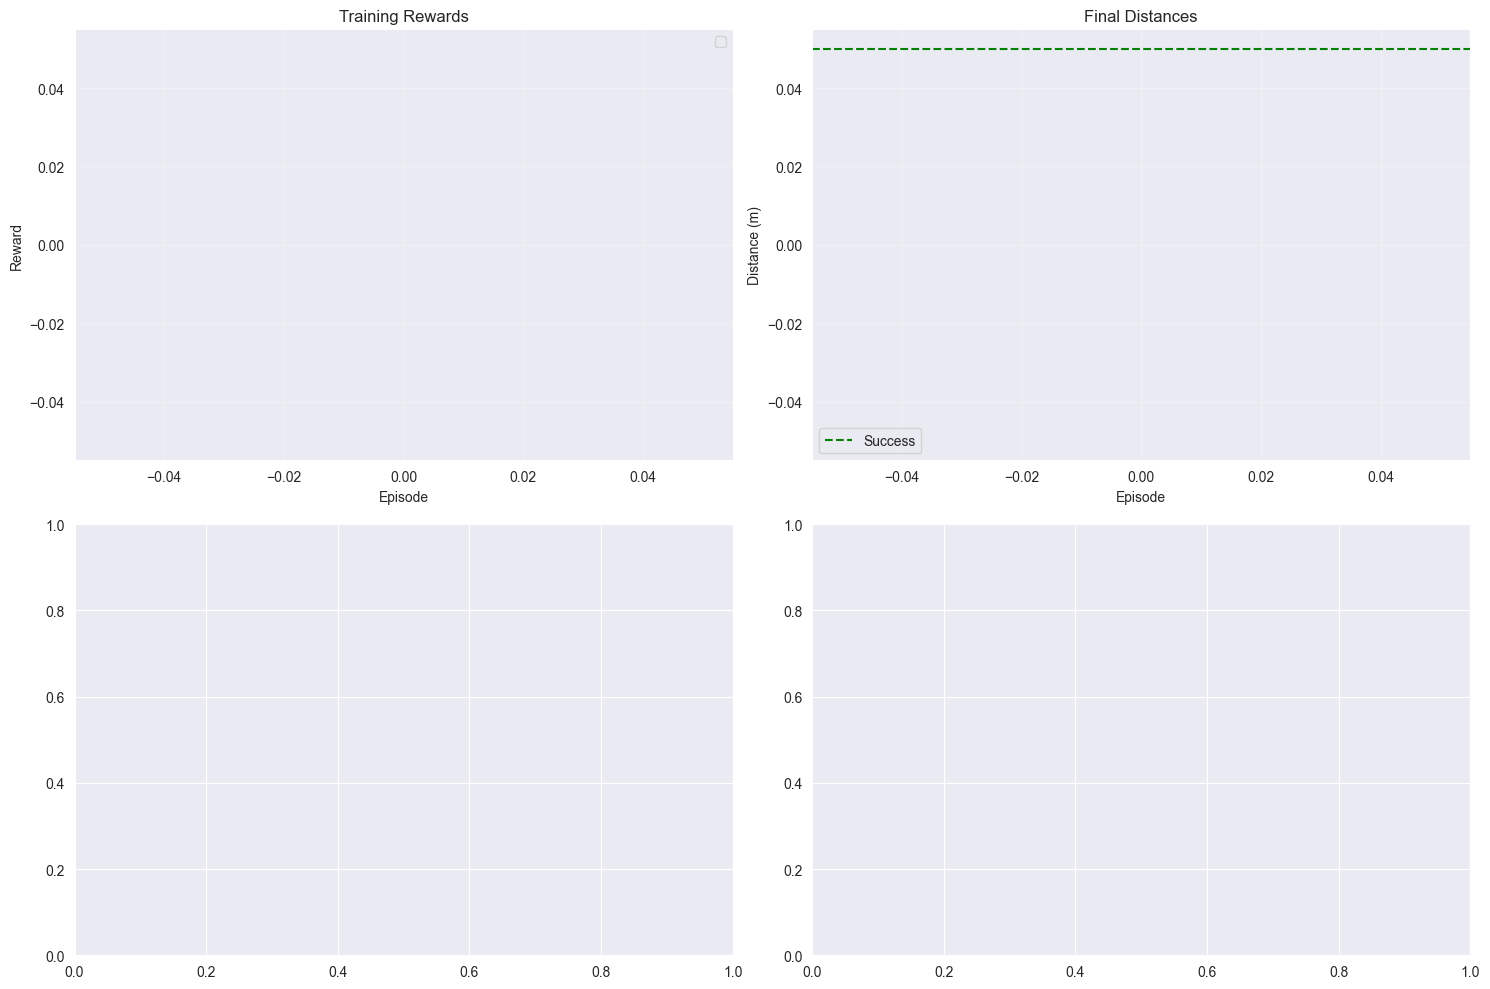

✅ Results plot saved


In [12]:
import pandas as pd

# Plot training progress
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Episode rewards
axes[0, 0].plot(training_stats['episode_rewards'], alpha=0.3)
if len(training_stats['episode_rewards']) > 100:
    ma = pd.Series(training_stats['episode_rewards']).rolling(100).mean()
    axes[0, 0].plot(ma, linewidth=2, label='100-episode MA')
axes[0, 0].set_title('Training Rewards')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Reward')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Final distances
axes[0, 1].plot(training_stats['episode_distances'], alpha=0.3)
if len(training_stats['episode_distances']) > 100:
    ma = pd.Series(training_stats['episode_distances']).rolling(100).mean()
    axes[0, 1].plot(ma, linewidth=2)
axes[0, 1].axhline(0.05, color='green', linestyle='--', label='Success')
axes[0, 1].set_title('Final Distances')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Distance (m)')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Evaluation rewards
if training_stats['eval_rewards']:
    axes[1, 0].plot(training_stats['eval_episodes'], 
                   training_stats['eval_rewards'], 
                   marker='o', linewidth=2)
    axes[1, 0].set_title('Evaluation Rewards')
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Mean Reward')
    axes[1, 0].grid(alpha=0.3)

# Success rate
if training_stats['eval_success_rates']:
    axes[1, 1].plot(training_stats['eval_episodes'], 
                   training_stats['eval_success_rates'], 
                   marker='s', linewidth=2, color='green')
    axes[1, 1].set_title('Success Rate')
    axes[1, 1].set_xlabel('Episode')
    axes[1, 1].set_ylabel('Success Rate (%)')
    axes[1, 1].set_ylim([0, 100])
    axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config['log_dir'], f"{config['exp_name']}_results.png"), 
           dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Results plot saved")

## 11. Test Trained Agent

In [14]:
# Load best model
best_path = os.path.join(config['checkpoint_dir'], f"{config['exp_name']}_best.pt")
agent.load(best_path)

# Evaluate
print("🎯 Final Evaluation (50 episodes)\n")
final_eval = evaluate_agent(agent, eval_env, num_episodes=50)

print(f"Mean Reward:    {final_eval['mean_reward']:.2f} ± {final_eval['std_reward']:.2f}")
print(f"Mean Distance:  {final_eval['mean_distance']:.4f}")
print(f"Success Rate:   {final_eval['success_rate']:.1f}% "
      f"({final_eval['success_count']}/50)")

🎯 Final Evaluation (50 episodes)

Mean Reward:    -51.73 ± 4.47
Mean Distance:  0.2490
Success Rate:   0.0% (0/50)


# 11.5. Visualise Agent Behaviour

In [19]:
# Cell 11.5: Visualize Agent Behavior (NEW)

print("🎬 Visualizing trained agent in action...\n")

# Setup virtual display for Colab
if IN_COLAB:
    print("Setting up virtual display...")
    !apt-get install -q xvfb python3-opengl > /dev/null 2>&1
    !pip install -q pyvirtualdisplay
    
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()
    
    import os
    os.environ['DISPLAY'] = f':{display.display}.0'
    os.environ['MUJOCO_GL'] = 'egl'
    print("✅ Virtual display ready\n")

# Record videos
from src.utils.record_video import record_evaluation_episodes

video_folder = os.path.join(config['video_dir'], 'visualization')
os.makedirs(video_folder, exist_ok=True)

print("🎥 Recording 5 episodes...")
video_results = record_evaluation_episodes(
    agent=agent,
    env_name=config['env_name'],
    video_folder=video_folder,
    num_episodes=5,
    max_steps=config['max_steps'],
    name_prefix="agent_behavior"
)

print(f"\n✅ Videos recorded!")
print(f"📁 Location: {video_folder}")
print(f"\n📊 Video Statistics:")
print(f"  Mean Reward: {video_results['mean_reward']:.2f}")
print(f"  Success Rate: {video_results['success_rate']:.1f}%")
print(f"  Mean Distance: {video_results['mean_distance']:.4f}m")

# Display first video in Colab
if IN_COLAB:
    import glob
    from IPython.display import Video
    
    videos = glob.glob(os.path.join(video_folder, "*.mp4"))
    if videos:
        print(f"\n🎬 Displaying first video:\n")
        display(Video(videos[0], width=600))
    else:
        print("⚠️ No videos found")

🎬 Visualizing trained agent in action...

🎥 Recording 5 episodes...
🎬 Recording 5 episodes...
📁 Videos will be saved to: C:\Users\USER\PycharmProjects\Pusher-Gym\notebooks\videos\visualization
  Episode 1: Reward=-82.94, Distance=0.2888, Steps=100
  Episode 2: Reward=-80.26, Distance=0.2135, Steps=100
  Episode 3: Reward=-76.37, Distance=0.1953, Steps=100
  Episode 4: Reward=-78.66, Distance=0.2666, Steps=100
  Episode 5: Reward=-72.43, Distance=0.2122, Steps=100

✅ Recording complete!
   Videos saved: C:\Users\USER\PycharmProjects\Pusher-Gym\notebooks\videos\visualization

✅ Videos recorded!
📁 Location: C:\Users\USER\PycharmProjects\Pusher-Gym\notebooks\videos\visualization

📊 Video Statistics:
  Mean Reward: -78.13
  Success Rate: 0.0%
  Mean Distance: 0.2353m


## 12. Download Results

Download checkpoints, videos, and logs to your local machine.

In [ ]:
if IN_COLAB:
    from google.colab import files
    import zipfile
    
    # Create zip of results
    zip_path = f"/content/{config['exp_name']}_results.zip"
    
    with zipfile.ZipFile(zip_path, 'w') as zipf:
        # Add checkpoints
        for file in checkpoint_dir.glob(f"{config['exp_name']}*.pt"):
            zipf.write(file, arcname=f"checkpoints/{file.name}")
        
        # Add logs
        for file in log_dir.glob(f"{config['exp_name']}*"):
            zipf.write(file, arcname=f"logs/{file.name}")
        
        # Add videos (if any)
        for file in video_dir.glob(f"{config['exp_name']}*.mp4"):
            zipf.write(file, arcname=f"videos/{file.name}")
    
    print(f"📦 Created zip: {zip_path}")
    print("⬇️ Downloading...")
    files.download(zip_path)
else:
    print("ℹ️ Running locally. Files already saved to project directory.")

---

## ✅ Training Complete!

### Next Steps:

1. **Analyze results**: Check the plots and statistics
2. **Watch videos**: View the recorded episodes
3. **Tune hyperparameters**: Adjust learning rate, batch size, etc.
4. **Try reward shaping**: Improve learning speed
5. **Compare algorithms**: Train with PPO and compare

### Tips:

- **Save to Drive**: All files are automatically saved to Google Drive
- **Resume training**: Just run the notebook again with `auto_resume=True`
- **Monitor GPU**: Check GPU memory if training crashes
- **Longer training**: Increase `episodes` for better performance

Happy training! 🚀